In [ ]:
import numpy as np
import random 
from IPython.display import clear_output
import matplotlib.pyplot as plt
# from keras.utils import to_categorical

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

## Настройка окружения

In [ ]:
def create_playground(playfield):

  '''
  Функция создания игрового поля
  Входные параметры:
   - playfield - размер игровой области
  Выходные параметры:
   - playground - поле размерность которого увеличина на 2 по отношению к playfield
  '''

  playground = np.zeros((playfield+2,playfield+2))

  return playground

In [ ]:
def create_minesfield(playfield):

  '''
  Функция создает пустое поле, где будут храниться мины
  Входные параметры:
   - playfield - размер игровой области
  Выходные параметры:
   - minesfield - поле размерность которого совпадает playfield
  '''
  
  minesfield = np.zeros((playfield,playfield))

  return minesfield

In [ ]:
def first_step(playfield):

  '''
  Функция задет координаты первого хода
  Входные параметры:
   - playfield - размер игровой области
  Выходные параметры:
   - (x,y) - координаты первого хода
  '''
  x = np.random.randint(0, playfield)
  y = np.random.randint(0, playfield)

  return (x,y)

In [ ]:
def place_mines(playfield, mines_count, actions):

  '''
  Функция для растоновки мин на поле
  Входные параметры:
   - playfield - размер игровой области
   - mines_count - количество мин
  Выходные параметры:
   - first_step_coord - координаты первого хода
   - mines_coord - список с кортежеми координат мин
  '''

  first_step_coord = first_step(playfield)
  
  mines_coord = []
  while len(mines_coord) <  mines_count:
    x = np.random.randint(0, playfield)
    y = np.random.randint(0, playfield)

    point_surround = []
    for act in actions:
      x1 = first_step_coord[0] + act[0]
      y1 = first_step_coord[1] + act[1]
      point_surround.append((x1,y1))

    if ((x, y) !=  first_step_coord) and ((x, y) not in mines_coord) and ((x, y) not in point_surround):

      mines_coord.append((x, y))


  return first_step_coord, mines_coord

In [ ]:
def mines_number(playground, playfield, mines_coord):

  '''
  Функция для заполнения карты мин вокруг
  Входные параметры:
   - playground - увеличенное игровое поле
   - playfield - размер игровой области
   - mines_coord - список с кортежеми координат мин
  Выходные параметры:
   - field - поле, в каждой клетке которого записано количетсво мин вокруг
  '''

  # Запишем координаты мин для расширенного поля
  mines_round = []
  for mine in mines_coord:
    mines_round.append((mine[0]+1, mine[1]+1))

  field = np.zeros((playfield+2, playfield+2))

  # Для каждой клетки игрового поля запишем число мин вокруг
  for i in range(1, playground.shape[0]-1):
    for j in range(1, playground.shape[1]-1):
      if (i,j) in mines_round:
        continue
      field_round = [(i-1,j-1), (i-1,j), (i-1,j+1),
                     (i,j-1), (i,j), (i,j+1),
                     (i+1,j-1), (i+1,j), (i+1,j+1)]
      mines_count = 0
      for point in field_round:
        mines_count += playground[point]
      field[i,j] = mines_count

  field = field[1:-1, 1:-1]

  return field

In [ ]:
def initialize_game(playfield, mines_count, actions):

  '''
  Функция инициализации игры
  Входные параметры:
   - playfield - размер игровой области
   - mines_count - количество мин
  Выходные параметры:
   - mines_coord - список с кортежеми координат мин
   - free_points - точки в которые уже сходили
   - mines_field - карта мин вокруг
  '''

  playground = create_playground(playfield)

  free_points = set()

  first_step_coord, mines_coord = place_mines(playfield, mines_count, actions)

  free_points.add(first_step_coord)

  for mine in mines_coord:
    x = mine[0] + 1
    y = mine[1] + 1
    playground[(x, y)] = 1

  mines_field = mines_number(playground, playfield, mines_coord)

  return mines_coord, free_points, mines_field

In [ ]:
def place_step(play, mines_field, free_points):

  '''
  Функция заполнения игрового поля точками, в которые сходили
  Входные параметры:
   - play - игровое поле
   - mines_field - карта мин вокруг
   - free_point - координаты точек, куда сходили
  Выходные параметры:
   - play - поле с новой открытой точкой
  '''
  
  for step in free_points:
    # print(step)
    play[step] = mines_field[step]

  return play

In [ ]:
def show_mines(play, mines_coord, next_point, free_points):

  '''
  Функция отображения мин и последоваиельности ходов
  Входные параметры:
   - play - игровое поле
   - mines_coord - координаты мин
   - next_point - координаты следующей точки
   - free_points - координаты точек, куда сходили
  Выходные параметры:
   - play - обновленное игровое поле
  '''

  for (x,y) in mines_coord:
    play[(x,y)] = -1

  i = 1
  for (x,y) in free_points:
    if (x,y) != next_point:
      play[(x,y)] = i
      i += 1
  
  # Поскольку игра завершается если наступить на мину, то отобразим послдений ход просто умножив i на мину(-1)
  if next_point in mines_coord:
    play[next_point] = i*play[next_point]
  else:
    try:
      play[next_point] = i
    except:
      print('Out of range')

  return play

In [ ]:
def play_minesweep(playfield, mines_count, bot_1, bot_2, seed=None, verbose=0):

  '''
  Функция для тренировки ботов игры в сапера
  Входные параметры:
   - playfield - размер игрового поля
   - mines_count - число мин
   - bot - бот
   - verbose - флаг визуализации процесса игры
  Выходные параметры:
   - play - обновленное игровое поле
  '''

  if seed != None:
    np.random.seed(seed)

  actions = [(-1,-1), (-1,0), (-1,1), (0,1), (1,1), (1,0), (1,-1), (0,-1)]
  play = create_minesfield(playfield)
  mines_coord, free_points, minesfield = initialize_game(playfield, mines_count, actions)

  done = False
  score = 0
  steps = 0
  fear_count = 1

  np.random.seed(None)

  while done != True:

    play = place_step(play, minesfield, free_points)

    next_point = action_vector(free_points, minesfield, play, bot_1, bot_2, actions, playfield, verbose)

    step_reward, done = check_state(next_point, free_points, mines_coord, done, play, minesfield, fear_count)

    # print(type(free_points[0]))

    free_points.add(next_point)

    # free_points = list(free_points)

    score += step_reward

    if step_reward < 0:
      fear_count += 1 + np.random.rand() / 10
    else:
      fear_count = 1

    steps += 1
    if steps > len(play.flatten()):
      done = True

  if verbose:
    show_result(play, free_points, mines_coord)
    print(score)

  return score

In [ ]:
def show_result(play, free_points, mines_coord):

  '''
  Функция отображения игрового поля
  Входные параметры:
   - play - игровое поле
   - free_points - координаты точек, куда сходили
   - mines_coord - координаты мин
  '''
  
  plt.imshow(play, cmap='Accent')
  plt.axis('off')
  for x in range(play.shape[0]):
    for y in range(play.shape[1]):
      if (x,y) in free_points:
        if (x,y) in mines_coord:
          label = 'boom!'
          plt.text(y, x, label, color='black', ha='center', va='center')
        else:
          label = play[(x, y)]
          plt.text(y, x, label, color='black', ha='center', va='center')
  plt.show()

## C этими функциями я пока что экспериментирую

### Функции расчета вектора для бота относительно выбранной точки

#### Предыдущие версии

In [ ]:
def point_vector(point, free_points, play, actions):

  action = []
  # wall_flags = np.array([0,0,0,0,0,0,0,0])
  # if point[0] == 0:
  #   wall_flags[0] = 1
  #   wall_flags[1] = 1
  #   wall_flags[2] = 1
  # if (point[0] == play.shape[0] - 1):
  #   wall_flags[4] = 1
  #   wall_flags[5] = 1
  #   wall_flags[6] = 1
  # if point[1] == 0:
  #   wall_flags[0] = 1
  #   wall_flags[7] = 1
  #   wall_flags[6] = 1
  # if (point[1] == play.shape[1] - 1):
  #   wall_flags[2] = 1
  #   wall_flags[3] = 1
  #   wall_flags[4] = 1
    
  for i, act in enumerate(actions):
    x = point[0] + act[0]
    y = point[1] + act[1]
    
    if (x, y) not in free_points:
        action.extend([1,0,0,0,0,0,0,0,0,0])
    else:
        ohe_point = [0,0,0,0,0,0,0,0,0,0]
        mines_index = int(play[(x,y)]) + 1
        ohe_point[mines_index] = 1
        action.extend(ohe_point)

#   mines_dict = {0: 9,
#                 1: 8,
#                 2: 7,
#                 3: 6,
#                 4: 5,
#                 5: 4,
#                 6: 3,
#                 7: 2,
#                 8: 1}

# #   mines_list = [1, 0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2]

#   free_point_flags = np.array([0,0,0,0,0,0,0,0]).astype('float32')
#   for i, act in enumerate(actions):

#     x = point[0] + act[0]
#     y = point[1] + act[1]
#     if (x, y) not in free_points and x in range(0,play.shape[0]) and y in range(0,play.shape[1]):
#       free_point_flags[i] = 1.0

    
#   mines_awere_flags = np.array([0,0,0,0,0,0,0,0]).astype('float32')
#   for i, act in enumerate(actions):

#     x = point[0] + act[0]
#     y = point[1] + act[1]
#     if (x, y) not in free_points and x in range(0,play.shape[0]) and y in range(0,play.shape[1]):
#       mines_awere_flags[i] = mines_dict[int(play[point])]
    
# #   print(mines_awere_flags, end=' ')

# #   print()


#   mines_intensity_flags = np.array([0,0,0,0,0,0,0,0]).astype('float32')
    
#   k = 0
#   for i, act in enumerate(actions):

#     x = point[0] + act[0]
#     y = point[1] + act[1]
#     if (x, y) not in free_points and x in range(0,play.shape[0]) and y in range(0,play.shape[1]):
#       k += 1
    
#   for i, act in enumerate(actions):

#     x = point[0] + act[0]
#     y = point[1] + act[1]
#     if (x, y) not in free_points and x in range(0,play.shape[0]) and y in range(0,play.shape[1]):
    
#       point_surroundings = []
#       for j, act1 in enumerate(actions):
#         x1 = x + act1[0]
#         y1 = y + act1[1]
#         if (x1, y1) in free_points:
#           point_surroundings.append(play[(x1,y1)])

#       mines_intensity_flags[i] = 9 - np.sum(point_surroundings)

    
#   action.extend(free_point_flags)
#   action.extend(mines_awere_flags)
#   action.extend(mines_intensity_flags)
#   action.append(k)

#   print(action)

  return action

0.0      106.57   0.0      50.62    0.0      
0.0      52.87    123.87   109.82   0.0      
0.0      0.0      0.0      0.0      0.0      
0.0      0.0      0.0      0.0      0.0      
0.0      0.0      0.0      0.0      0.0      

0.0      87.77    51.13    83.39    0.0      
0.0      99.43    40.83    65.85    0.0      
0.0      68.62    161.68   172.71   0.0      
0.0      0.0      0.0      0.0      0.0      
0.0      0.0      0.0      0.0      0.0      

0.0      80.58    32.65    81.62    0.0      
0.0      82.93    37.46    82.43    44.28    
0.0      82.81    134.76   96.43    13.57    
0.0      0.0      3.25     59.37    66.97    
0.0      0.0      0.0      0.0      0.0      

0.0      90.43    -1.09    68.22    0.0      
0.0      80.09    32.17    74.63    47.93    
0.0      85.74    85.77    30.32    6.3      
0.0      47.47    35.4     59.29    50.93    
0.0      0.0      0.0      0.0      0.0      

7.65     78.0     -1.3     45.95    0.0      
23.19    78.16    21.09    65.

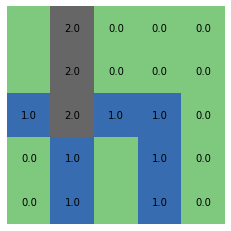

4.88939279283632


4.88939279283632

In [ ]:
playfield = 5
mines_count = 3
play_minesweep(playfield, mines_count, popul[0], seed=None, verbose=1)

### Функции выбора следующей точки

#### Предыдущие версии

#### Актуальная

Уберем ограничение на хождение в уже открытую точку

In [ ]:
def action_vector(free_points, minesfield, play, bot_1, bot_2, actions, playfield, verbose):

  step_field = np.zeros((playfield+2, playfield+2))
  step_field_2 = np.zeros((playfield+2, playfield+2))
  dev_field = np.zeros((playfield+2, playfield+2))
    
  for x in range(1, playfield+2):
    for y in range(1, playfield+2):
        if (x-1, y-1) not in free_points:
            point = (x-1, y-1)
            action = point_vector(point, free_points, play, actions)
            point_score = np.dot(action, bot_2)
            
            step_field_2[(x,y)] = point_score
            
  step_field_2 = step_field_2[1:-1, 1:-1]
#   step_field_2 = step_field_2 / np.max(step_field_2)

  # x_points = []

  # for x in range(playfield):
  #   for y in range(playfield):
  #     x_points.append((x,y))

  # x_points = set(x_points) - set(free_points)

  for point in free_points:

    action = point_vector(point, free_points, play, actions)
    action = np.dot(action, bot_1)
    # print(action)

    for i, act in enumerate(actions):
      x = point[0] + act[0] + 1
      y = point[1] + act[1] + 1
        
      if (x-1,y-1) not in free_points:
        step_field[(x,y)] = step_field[(x,y)] + action[i]
        dev_field[(x,y)] = dev_field[(x,y)] + 1

  dev_field[dev_field == 0] = 1
  # zeros_ind = np.where(dev_field.flatten() == 0)[0]
  # dev_field = dev_field.flatten()
  # dev_field[zeros_ind] = 1
  # dev_field = dev_field.reshape(playfield+2, playfield+2)
  step_field = step_field / dev_field


  step_field = step_field[1:-1, 1:-1]
#   step_field = step_field / np.max(step_field)
    
  step_field = step_field + step_field_2

  # for i in step_field:
  #   for j in i:
  #     print(str(round(j,2)) + ' '*(8-len(str(round(j,2)))), end=' ')
  #   print()

#   for point in free_points:
#     step_field[point] = 0

#   active_points = np.where(step_field.flatten() != 0)[0]
#   # print(active_points)

#   if len(active_points) > 1:
#     for point in active_points:
#       p1, p2 = (point//(playfield), (point - (point//(playfield)) * (playfield)))
#       # print((p1, p2))
#       point_surroundings = []
#       for i, act in enumerate(actions):
#         x = p1 + act[0]
#         y = p2 + act[1]
#         if (x, y) in free_points:
#           # print((x, y))
#           point_surroundings.append(play[(x,y)])
      
#       # if np.min(point_surroundings) == 0:
#       step_field[(p1,p2)] = step_field[(p1,p2)] / (np.min(point_surroundings) + 1)

  next_step = np.argmax(step_field)
  # print(next_step)
  next_step_coord = (next_step//(playfield), (next_step - (next_step//(playfield)) * (playfield)))

  if verbose:

    if next_step_coord in free_points:
      action = point_vector(next_step_coord, free_points, play, actions)
      print(action)
#       print(play[next_step_coord])

    for x, i in enumerate(step_field):
      for y, j in enumerate(i):
        # print(str(round(j,2)) + ' '*(8-len(str(round(j,2)))), end=' ')
        if j == step_field[next_step_coord]:
          print('\033[0;37;45m' + str(round(j,2)) + '\033[0;37;48m' + ' '*(8-len(str(round(j,2)))), end=' ')
        elif (x,y) in free_points:
          print('\033[0;37;44m' + str(round(j,2)) + '\033[0;37;48m' + ' '*(8-len(str(round(j,2)))), end=' ')
        else:
          print(str(round(j,2)) + ' '*(8-len(str(round(j,2)))), end=' ')
      print()
    print()

  return next_step_coord

### Функции проверки состояния

#### Пердыдущие версии

#### Актуальная

Награда с учетом выбора уже схоженной точки

In [ ]:
def check_state(next_point, free_points, mines_coord, done, play, minesfield, fear_count):

  if next_point in free_points:
    done = done
    step_reward = -0.75 * fear_count
    return step_reward, done

  if next_point in mines_coord:
    done = True
    step_reward = -100
    return step_reward, done

  if (next_point not in free_points) and (next_point not in mines_coord):

    if (len(play.flatten()) - len(free_points) - 1) == len(mines_coord):
      done = True
      step_reward = 100
      return step_reward, done

    done = done
    step_reward = 1 + np.random.rand() / 10
    return step_reward, done

  # if (next_point[0] == play.shape[0]) or (next_point[0] == -1):
  #   done = True
  #   step_reward = -100
  #   return step_reward, done

  # if (next_point[1] == play.shape[1]) or (next_point[1] == -1):
  #   done = True
  #   step_reward = -100
  #   return step_reward, done

  # step_reward = (len(free_points) / 10) - minesfield[next_point]

  return step_reward, done

## Обучение и результаты

In [ ]:
# Создадим бота в соответствии с актуальными размерами
bot_1 = np.random.random((80,8))
bot_1_param = bot_1.shape[0]
bot_1_actions = bot_1.shape[1]

bot_2 = np.random.random((80,1))
bot_2_param = bot_2.shape[0]
bot_2_actions = bot_2.shape[1]

0.7      1.52     1.9      1.51     0.7      
0.7      1.71     0.0      1.88     0.7      
0.7      1.61     1.79     1.48     0.7      
0.7      0.7      0.7      0.7      0.7      
0.7      0.7      0.7      0.7      0.7      

0.79     1.69     0.0      1.9      0.79     
0.79     1.65     0.0      1.86     0.79     
0.79     1.84     1.79     1.54     0.79     
0.79     0.79     0.79     0.79     0.79     
0.79     0.79     0.79     0.79     0.79     

0.72     1.41     0.0      0.0      1.59     
0.72     1.47     0.0      1.85     1.84     
0.72     1.75     1.53     1.39     0.72     
0.72     0.72     0.72     0.72     0.72     
0.72     0.72     0.72     0.72     0.72     

0.8      1.53     0.0      0.0      1.52     
0.8      1.53     0.0      0.0      1.75     
0.8      1.85     1.45     1.64     1.61     
0.8      0.8      0.8      0.8      0.8      
0.8      0.8      0.8      0.8      0.8      

0.8      1.69     0.0      0.0      1.69     
1.62     1.74     0.0      0.0

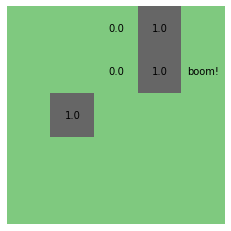

-95.88616048023064


-95.88616048023064

In [ ]:
# Проверим работоспособность игры
playfield = 5
mines_count = 3
play_minesweep(playfield, mines_count, bot_1, bot_2, seed=None, verbose=1)

Нулевые точки хорошо открываются даже без обучения.

In [ ]:
# Создадим популяцию
popul_1 = []
popul_2 = []
numBots = 100

for i in range(numBots):
  popul_1.append(np.random.random(size=(bot_1_param, bot_1_actions)) - 0.5)

for i in range(numBots):
  popul_2.append(np.random.random(size=(bot_2_param, bot_2_actions)) - 0.5)

In [ ]:
# Стандартные функции для отбора ботов и их скрещикания

def getSurvPopul(popul_1, popul_2, val, nsurv):
  newpopul_1 = []
  newpopul_2 = []

  sval = sorted(val, reverse=True)
  for i in range(nsurv):
    newpopul_1.append(popul_1[val.index(sval[i])])
    newpopul_2.append(popul_2[val.index(sval[i])])

  return newpopul_1, newpopul_2, sval


def getParents(curr_popul, nsurv):
  index1 = np.random.randint(0, nsurv)
  index2 = np.random.randint(0, nsurv)
  bot1 = curr_popul[index1].copy()
  bot2 = curr_popul[index2].copy()

  return bot1, bot2


def crossPointFromParents(bot1, bot2, j, mut, mut_coef):

  if random.random() > 0.5:
    x = bot1[j].copy()
  else:
    x = bot2[j].copy()

  if random.random() < mut_coef:
    x = x + (random.random()-0.5)*np.random.uniform(0, mut)

  return x

In [ ]:
mut = 10
for i in range(1000):
    mut = mut * 0.995
print(mut)

0.06653968578831973


In [ ]:
# Пусть выживут сильнейшие :)
epochs = 1200
n = 100
nsurv = 20
nnew = n - nsurv
mut = 10
mut_coef = 0.5
playfield = 8
mines_count = 10
seed = 0
results = []

l1 = popul_1[0].shape[0]*popul_1[0].shape[1]
l2 = popul_2[0].shape[0]*popul_2[0].shape[1]

for epoch in range(epochs):
    
#   if epoch > 2500:
#     mut_coef = 0.25
#   if epoch > 4000:
#     mut_coef = 0.1
  mut = mut * 0.995
  
  val = []

  for i in range(n):

    val.append(play_minesweep(playfield, mines_count, popul_1[i], popul_2[i], seed=epoch))

  new_popul_1, new_popul_2, sval = getSurvPopul(popul_1, popul_2, val, nsurv)

  print(f'{epoch}, {np.mean(sval)}, {sval[:5]}')
  results.append(sval[0])

  for i in range(nnew):
    bot1, bot2 = getParents(new_popul_1, nsurv)

    new_bot = []

    for j in range(l1):
      x = crossPointFromParents(bot1.flatten(), bot2.flatten(), j, mut, mut_coef)
      new_bot.append(x)
      
    new_popul_1.append(np.array(new_bot).reshape(bot_1_param, bot_1_actions))

  popul_1 = np.array(new_popul_1)

  for i in range(nnew):
    bot1, bot2 = getParents(new_popul_2, nsurv)

    new_bot = []

    for j in range(l2):
      x = crossPointFromParents(bot1.flatten(), bot2.flatten(), j, mut, mut_coef)
      new_bot.append(x)
      
    new_popul_2.append(np.array(new_bot).reshape(bot_2_param, bot_2_actions))

  popul_2 = np.array(new_popul_2)

  if epoch % 200 == 0:
    np.save('E://учеба/diplom/popul_together_1.npy', popul_1)
    np.save('E://учеба/diplom/popul_together_2.npy', popul_2)
    np.save('E://учеба/diplom/results_together.npy', np.array(results))

0, -522.652817369311, [-72.61800443658119, -75.7730416622951, -77.82946536978329, -77.97754586660587, -79.09874043983166]
1, -200.80416800505475, [-71.63045949253203, -80.14912629403085, -82.32672028021368, -83.02886237400989, -84.17521393316707]
2, -355.8007190073378, [-68.39950638514337, -77.90358900431659, -78.07027698257936, -81.02483310365673, -83.17770840765569]
3, -205.4271430677226, [-79.84793984863677, -80.96793569686817, -81.14029253841906, -82.27049922382501, -83.20648973641792]
4, -193.86798452144544, [-69.63368410807922, -80.24923877273913, -82.16792842506716, -83.0290195407572, -84.25344070846842]
5, -185.84562649665295, [-55.95787072242404, -74.87286810682451, -77.84858447998039, -77.8729029543536, -78.88533389114228]
6, -140.68979606592472, [-64.10248869874249, -80.11213442412743, -82.12880009980876, -82.29128962812518, -84.3509747787484]
7, -170.09015518834704, [-75.72582128964856, -79.99698053812652, -80.95640514021883, -81.82640059277223, -82.39637029530111]
8, -123.

10.78    10.78    10.78    10.78    10.78    
10.78    10.78    10.78    10.78    10.78    
10.78    10.78    10.78    10.78    10.78    
10.78    10.78    10.78    -6.13    26.87    
10.78    10.78    10.78    33.84    0.0      

10.78    10.78    10.78    10.78    10.78    
10.78    10.78    10.78    10.78    10.78    
10.78    10.78    10.78    10.78    10.78    
10.78    10.78    -9.2     41.67    57.81    
10.78    10.78    26.33    0.0      0.0      

10.78    10.78    10.78    10.78    10.78    
10.78    10.78    10.78    10.78    10.78    
10.78    10.78    10.78    5.18     23.83    
10.78    10.78    -2.49    81.19    0.0      
10.78    10.78    18.3     0.0      0.0      

10.78    10.78    10.78    10.78    10.78    
10.78    10.78    10.78    10.78    10.78    
10.78    10.78    -31.25   15.29    28.61    
10.78    10.78    25.47    0.0      0.0      
10.78    10.78    22.84    0.0      0.0      

10.78    10.78    10.78    10.78    10.78    
10.78    10.78    10.78    -6.

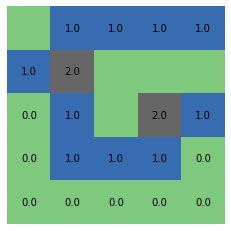

-1.751565417914053


-1.751565417914053

In [ ]:
playfield = 5
mines_count = 3
play_minesweep(playfield, mines_count, popul_1[0], popul_2[0], seed=None, verbose=1)